# CS 269Q: Final Project - QAOA on MIS
***
## Part 2: Using Grid Search 
Using Peter Karalekas' [notebook](https://gist.github.com/karalekas/c63b0bb24f15109f1921cea5966ca518) as reference.

__Note:__ Please see Part 1: Using Classical Optimizer first which is documented in another notebook.

__GOAL:__ Generate random MIS instances for simulation on the QVM and the QPU. Check how performance scales with width.

In [ ]:
from pyquil import Program
from pyquil.gates import I, X, RESET
from pyquil.api import WavefunctionSimulator, QPU, QuantumComputer
from pyquil.paulis import sZ, sX, sI, exponentiate_commuting_pauli_sum

import itertools
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List, Tuple

We will again be using Mathematica to generate the graphs. Thus, following string processing function is required. 

In [5]:
def elist_from_math(string):
    string = string.replace(',','), (')
    string = string.replace(' <->',',')
    return eval('(' + string + ')')

Defining the cost and driver Hamiltonians along with the ansatz:

In [6]:
def get_hamil(num_nodes, edge_list, delta, U, omega):
    nodes = list(range(0,num_nodes))
    edges = [(i-1,j-1) for i,j in edge_list]
    h_cost = -0.5* delta * sum((sI(i) - sZ(i)) for i in nodes) + 0.25 * U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    h_driver = omega*sum(sX(i) for i in nodes) + 0.25*U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    return h_cost, h_driver

In [1]:
def mis_ansatz(betas, gammas):
    pq = Program(RESET())
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    pq.measure_all()
    return pq

Given a bitstring for the state, we can calculate how good or bad the we expect the solution to be using: 

In [2]:
def bit_energy(bitstring, h_cost):
    size = len(bitstring)
    pq = Program()
    for i in range(size):
        if bitstring[i] == 0:
            pq += Program(I(i))
        elif bitstring[i] == 1:
            pq += Program(X(i))
    return np.real(WavefunctionSimulator().expectation(prep_prog = pq, pauli_terms = h_cost))

In [8]:
def calc_energy(beta, gamma):
    p = Program(RESET())
    p += mis_ansatz(beta,gamma)
    p.wrap_in_numshots_loop(shots)
    binary = qvm.compile(p) if isinstance(qvm.qam, QPU) else p
    bitstrings = qvm.run(binary)
    energy = np.mean([bit_energy(b, h_cost) for b in bitstrings])
    print('Calculated Cost:',energy)

__Note:__ The number of 'angle_range's in the itertools line dictates the circuit depth p. For each p, there should be 2 additional parameters.

In [4]:
def run_mis_qaoa_landscape(qc: QuantumComputer, num_nodes, edge_list, delta, U, omega, width: int,
                              shots: int = 1000) -> np.ndarray:
   
    beta_lst = []
    gamma_lst = []
    costs = []
    angle_range = np.linspace(0, np.pi, width)
    landscape = list(itertools.product(angle_range, angle_range)) # set p here
    for lst in tqdm(landscape):
        half = int(len(lst)/2)
        betas, gammas = lst[:half], lst[half:]
        
        p = mis_ansatz(betas, gammas)
        p.wrap_in_numshots_loop(shots)
        
        binary = qc.compile(p) if isinstance(qc.qam, QPU) else p
        bitstrings = qvm.run(binary)
        energy = np.mean([bit_energy(b, h_cost) for b in bitstrings])
        costs.append(energy)
        beta_lst.append(betas)
        gamma_lst.append(gammas)
        
    return costs, beta_lst, gamma_lst, np.array(costs).reshape(width, width)

The following plotting function results in a useful 2D contour plot for p = 1. The green dot is used to highlight the minimum on the landscape and the red dot to highlight the maximum.

In [25]:
def plot_landscape(landscape: np.ndarray, *, device: str, edges: List[Tuple[int, int]],
                   width: int, shots: int):
    max_x, max_y = (np.argmax(landscape) % width, np.argmax(landscape) // width)
    min_x, min_y = (np.argmin(landscape) % width, np.argmin(landscape) // width)
    plt.imshow(landscape, extent=[0, np.pi, np.pi, 0])
    plt.plot((max_x + 0.5) * np.pi / width, (max_y + 0.5) * np.pi / width, 'ro')
    plt.plot((min_x + 0.5) * np.pi / width, (min_y + 0.5) * np.pi / width, 'go')
    plt.colorbar()
    plt.xlabel('gamma (radians)')
    plt.ylabel('beta (radians)')
    plt.title(f'MIS QAOA Landscape\n{device}\n{edges}\nwidth = {width} shots = {shots}')
    plt.show()

In [7]:
def optimal_params(costs, beta, gamma):
    min_cost = costs[np.argmin(costs)]
    beta = beta[np.argmin(costs)]
    gamma = gamma[np.argmin(costs)]
    print("The minimum cost is:", min_cost)
    print("The optimal beta value(s):",beta)
    print("The optimal gamma value(s):",gamma)
    return beta, gamma

#### Running the Grid Search

1. Update the qvm to be used based on the number of qubits required to encode the graph.

In [9]:
from pyquil import get_qc

qvm = get_qc('5q-qvm')  # edit as necessary

2. Set the edge list, the values of the hyperparameters, the width of the search and the number of shots each parameter set is evaluated for.

In [10]:
string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 3, 2 <-> 4, 2 <-> 5, 3 <-> 4, 4 <-> 5'
elist = elist_from_math(string)

width = 10
shots = 100
num_nodes = 5  # edit as necessary
delta = 1
U = 1.5
omega = 0.5

h_cost, h_driver = get_hamil(num_nodes, elist, delta, U, omega)

3. Run the landscape search and plot the results.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:10<00:00,  1.81s/it]


The minimum cost is: -0.525
The optimal beta value(s): (1.0471975511965976,)
The optimal gamma value(s): (2.443460952792061,)


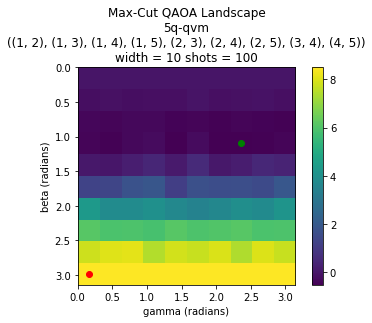

In [10]:
costs, beta, gamma, plot = run_mis_qaoa_landscape(qvm, num_nodes, elist, delta, U, omega, width, shots)
optimal_params(costs, beta, gamma)
plot_landscape(plot, device=qvm.name, edges=elist, width=width, shots=shots)

To check that the answer provided by the landscape searchis reasonble, use the parameters obtained and calculate the expected cost.

In [13]:
# SANITY CHECK
b,g = optimal_params(costs, beta, gamma)

p = Program(RESET())
p += mis_ansatz(b,g)
p.wrap_in_numshots_loop(shots)
binary = qvm.compile(p) if isinstance(qvm.qam, QPU) else p
bitstrings = qvm.run(binary)
energy = np.mean([bit_energy(b, h_cost) for b in bitstrings])
print('Calculated Cost:',energy)

The minimum cost is: -0.525
The optimal beta value(s): (1.0471975511965976,)
The optimal gamma value(s): (2.443460952792061,)
Calculated Cost: -0.415


### Additional Runs



  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:00<00:19,  1.26it/s]

  8%|▊         | 2/25 [00:01<00:17,  1.34it/s]

 12%|█▏        | 3/25 [00:02<00:15,  1.41it/s]

 16%|█▌        | 4/25 [00:02<00:14,  1.46it/s]

 20%|██        | 5/25 [00:03<00:13,  1.50it/s]

 24%|██▍       | 6/25 [00:03<00:12,  1.54it/s]

 28%|██▊       | 7/25 [00:04<00:11,  1.57it/s]

 32%|███▏      | 8/25 [00:05<00:10,  1.58it/s]

 36%|███▌      | 9/25 [00:05<00:10,  1.59it/s]

 40%|████      | 10/25 [00:06<00:09,  1.61it/s]

 44%|████▍     | 11/25 [00:07<00:08,  1.60it/s]

 48%|████▊     | 12/25 [00:07<00:08,  1.61it/s]

 52%|█████▏    | 13/25 [00:08<00:07,  1.61it/s]

 56%|█████▌    | 14/25 [00:08<00:06,  1.61it/s]

 60%|██████    | 15/25 [00:09<00:06,  1.62it/s]

 64%|██████▍   | 16/25 [00:10<00:05,  1.62it/s]

 68%|██████▊   | 17/25 [00:10<00:04,  1.63it/s]

 72%|███████▏  | 18/25 [00:11<00:04,  1.62it/s]

 76%|███████▌  | 19/25 [00:11<00:03,  1.62it/s]

 80%|████████  | 20/25 [00:12<00:03,

The minimum cost is: -0.51
The optimal beta value(s): (0.7853981633974483,)
The optimal gamma value(s): (0.0,)


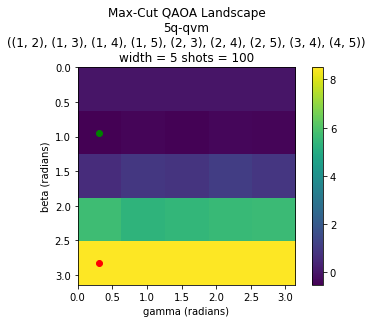

Calculated Cost: -0.41


In [21]:
width = 5

costs, betas, gammas, plot = run_mis_qaoa_landscape(qvm, num_nodes, elist, delta, U, omega, width, shots)
beta, gamma = optimal_params(costs, betas, gammas)
plot_landscape(plot, device=qvm.name, edges=elist, width=width, shots=shots)

calc_energy(beta, gamma)

In [ ]:
width = 12

costs, betas, gammas, plot = run_mis_qaoa_landscape(qvm, num_nodes, elist, delta, U, omega, width, shots)
beta, gamma = optimal_params(costs, betas, gammas)
plot_landscape(plot, device=qvm.name, edges=elist, width=width, shots=shots)

calc_energy(beta, gamma)



  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 1/225 [00:00<02:48,  1.33it/s]

  1%|          | 2/225 [00:01<02:43,  1.36it/s]

  1%|▏         | 3/225 [00:02<02:36,  1.42it/s]

  2%|▏         | 4/225 [00:02<02:30,  1.47it/s]

  2%|▏         | 5/225 [00:03<02:23,  1.53it/s]

  3%|▎         | 6/225 [00:03<02:19,  1.56it/s]

  3%|▎         | 7/225 [00:04<02:17,  1.59it/s]

  4%|▎         | 8/225 [00:05<02:14,  1.61it/s]

  4%|▍         | 9/225 [00:05<02:11,  1.64it/s]

  4%|▍         | 10/225 [00:06<02:17,  1.56it/s]

  5%|▍         | 11/225 [00:06<02:14,  1.60it/s]

  5%|▌         | 12/225 [00:07<02:12,  1.60it/s]

  6%|▌         | 13/225 [00:08<02:11,  1.62it/s]

  6%|▌         | 14/225 [00:08<02:09,  1.63it/s]

  7%|▋         | 15/225 [00:09<02:07,  1.64it/s]

  7%|▋         | 16/225 [00:10<02:07,  1.64it/s]

  8%|▊         | 17/225 [00:10<02:06,  1.64it/s]

  8%|▊         | 18/225 [00:11<02:04,  1.66it/s]

  8%|▊         | 19/225 [00:11<02:03,  1.66it/s]

  9%|▉         |

The minimum cost is: -0.64
The optimal beta value(s): (1.121997376282069,)
The optimal gamma value(s): (0.0,)


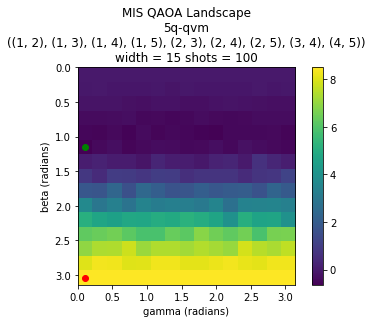

Calculated Cost: -0.31


In [26]:
width = 15

costs, betas, gammas, plot = run_mis_qaoa_landscape(qvm, num_nodes, elist, delta, U, omega, width, shots)
beta, gamma = optimal_params(costs, betas, gammas)
plot_landscape(plot, device=qvm.name, edges=elist, width=width, shots=shots)

calc_energy(beta, gamma)



  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 1/400 [00:00<05:06,  1.30it/s]

  0%|          | 2/400 [00:01<04:56,  1.34it/s]

  1%|          | 3/400 [00:02<04:47,  1.38it/s]

  1%|          | 4/400 [00:02<04:42,  1.40it/s]

  1%|▏         | 5/400 [00:03<04:35,  1.43it/s]

  2%|▏         | 6/400 [00:04<04:33,  1.44it/s]

  2%|▏         | 7/400 [00:04<04:30,  1.45it/s]

  2%|▏         | 8/400 [00:05<04:26,  1.47it/s]

  2%|▏         | 9/400 [00:06<04:22,  1.49it/s]

  2%|▎         | 10/400 [00:06<04:28,  1.45it/s]

  3%|▎         | 11/400 [00:07<04:28,  1.45it/s]

  3%|▎         | 12/400 [00:08<04:27,  1.45it/s]

  3%|▎         | 13/400 [00:08<04:27,  1.45it/s]

  4%|▎         | 14/400 [00:09<04:30,  1.42it/s]

  4%|▍         | 15/400 [00:10<04:29,  1.43it/s]

  4%|▍         | 16/400 [00:11<04:32,  1.41it/s]

  4%|▍         | 17/400 [00:11<04:31,  1.41it/s]

  4%|▍         | 18/400 [00:12<04:21,  1.46it/s]

  5%|▍         | 19/400 [00:13<04:14,  1.50it/s]

  5%|▌         |

 72%|███████▏  | 288/400 [03:01<01:08,  1.63it/s]

 72%|███████▏  | 289/400 [03:01<01:07,  1.64it/s]

 72%|███████▎  | 290/400 [03:02<01:07,  1.64it/s]

 73%|███████▎  | 291/400 [03:03<01:06,  1.64it/s]

 73%|███████▎  | 292/400 [03:03<01:06,  1.63it/s]

 73%|███████▎  | 293/400 [03:04<01:06,  1.62it/s]

 74%|███████▎  | 294/400 [03:04<01:06,  1.59it/s]

 74%|███████▍  | 295/400 [03:05<01:05,  1.61it/s]

 74%|███████▍  | 296/400 [03:06<01:04,  1.62it/s]

 74%|███████▍  | 297/400 [03:06<01:03,  1.62it/s]

 74%|███████▍  | 298/400 [03:07<01:02,  1.62it/s]

 75%|███████▍  | 299/400 [03:07<01:01,  1.63it/s]

 75%|███████▌  | 300/400 [03:08<01:01,  1.64it/s]

 75%|███████▌  | 301/400 [03:09<01:00,  1.64it/s]

 76%|███████▌  | 302/400 [03:09<00:59,  1.63it/s]

 76%|███████▌  | 303/400 [03:10<00:59,  1.64it/s]

 76%|███████▌  | 304/400 [03:11<00:58,  1.63it/s]

 76%|███████▋  | 305/400 [03:11<00:58,  1.63it/s]

 76%|███████▋  | 306/400 [03:12<00:57,  1.63it/s]

 77%|███████▋  | 307/400 [03:12

The minimum cost is: -0.565
The optimal beta value(s): (0.8267349088394192,)
The optimal gamma value(s): (1.8188167994467224,)


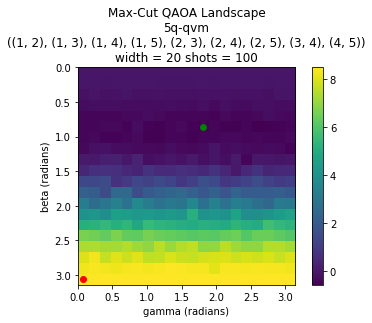

Calculated Cost: -0.44


In [14]:
width = 20

costs, betas, gammas, plot = run_mis_qaoa_landscape(qvm, num_nodes, elist, delta, U, omega, width, shots)
beta, gamma = optimal_params(costs, betas, gammas)
plot_landscape(plot, device=qvm.name, edges=elist, width=width, shots=shots)

calc_energy(beta, gamma)



  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 1/625 [00:00<07:11,  1.45it/s]

  0%|          | 2/625 [00:01<07:04,  1.47it/s]

  0%|          | 3/625 [00:01<06:56,  1.49it/s]

  1%|          | 4/625 [00:02<06:47,  1.53it/s]

  1%|          | 5/625 [00:03<06:39,  1.55it/s]

  1%|          | 6/625 [00:03<06:33,  1.57it/s]

  1%|          | 7/625 [00:04<06:29,  1.59it/s]

  1%|▏         | 8/625 [00:05<06:28,  1.59it/s]

  1%|▏         | 9/625 [00:05<06:25,  1.60it/s]

  2%|▏         | 10/625 [00:06<06:25,  1.60it/s]

  2%|▏         | 11/625 [00:06<06:22,  1.61it/s]

  2%|▏         | 12/625 [00:07<06:22,  1.60it/s]

  2%|▏         | 13/625 [00:08<06:22,  1.60it/s]

  2%|▏         | 14/625 [00:08<06:20,  1.60it/s]

  2%|▏         | 15/625 [00:09<06:18,  1.61it/s]

  3%|▎         | 16/625 [00:10<06:15,  1.62it/s]

  3%|▎         | 17/625 [00:10<06:21,  1.60it/s]

  3%|▎         | 18/625 [00:11<06:23,  1.58it/s]

  3%|▎         | 19/625 [00:11<06:26,  1.57it/s]

  3%|▎         |

 46%|████▌     | 288/625 [03:04<03:33,  1.58it/s]

 46%|████▌     | 289/625 [03:04<03:32,  1.58it/s]

 46%|████▋     | 290/625 [03:05<03:32,  1.58it/s]

 47%|████▋     | 291/625 [03:06<03:31,  1.58it/s]

 47%|████▋     | 292/625 [03:06<03:29,  1.59it/s]

 47%|████▋     | 293/625 [03:07<03:30,  1.58it/s]

 47%|████▋     | 294/625 [03:08<03:31,  1.56it/s]

 47%|████▋     | 295/625 [03:08<03:31,  1.56it/s]

 47%|████▋     | 296/625 [03:09<03:27,  1.58it/s]

 48%|████▊     | 297/625 [03:09<03:29,  1.56it/s]

 48%|████▊     | 298/625 [03:10<03:28,  1.57it/s]

 48%|████▊     | 299/625 [03:11<03:27,  1.57it/s]

 48%|████▊     | 300/625 [03:11<03:26,  1.57it/s]

 48%|████▊     | 301/625 [03:12<03:27,  1.56it/s]

 48%|████▊     | 302/625 [03:13<03:24,  1.58it/s]

 48%|████▊     | 303/625 [03:13<03:34,  1.50it/s]

 49%|████▊     | 304/625 [03:14<03:33,  1.50it/s]

 49%|████▉     | 305/625 [03:15<03:31,  1.52it/s]

 49%|████▉     | 306/625 [03:15<03:29,  1.52it/s]

 49%|████▉     | 307/625 [03:16

 92%|█████████▏| 574/625 [06:06<00:32,  1.57it/s]

 92%|█████████▏| 575/625 [06:06<00:31,  1.59it/s]

 92%|█████████▏| 576/625 [06:07<00:30,  1.59it/s]

 92%|█████████▏| 577/625 [06:08<00:30,  1.58it/s]

 92%|█████████▏| 578/625 [06:08<00:30,  1.56it/s]

 93%|█████████▎| 579/625 [06:09<00:29,  1.57it/s]

 93%|█████████▎| 580/625 [06:10<00:28,  1.56it/s]

 93%|█████████▎| 581/625 [06:10<00:28,  1.56it/s]

 93%|█████████▎| 582/625 [06:11<00:28,  1.52it/s]

 93%|█████████▎| 583/625 [06:12<00:28,  1.48it/s]

 93%|█████████▎| 584/625 [06:12<00:27,  1.49it/s]

 94%|█████████▎| 585/625 [06:13<00:26,  1.50it/s]

 94%|█████████▍| 586/625 [06:14<00:25,  1.52it/s]

 94%|█████████▍| 587/625 [06:14<00:24,  1.53it/s]

 94%|█████████▍| 588/625 [06:15<00:23,  1.55it/s]

 94%|█████████▍| 589/625 [06:16<00:23,  1.55it/s]

 94%|█████████▍| 590/625 [06:16<00:22,  1.55it/s]

 95%|█████████▍| 591/625 [06:17<00:22,  1.52it/s]

 95%|█████████▍| 592/625 [06:18<00:21,  1.54it/s]

 95%|█████████▍| 593/625 [06:18

The minimum cost is: -0.58
The optimal beta value(s): (0.7853981633974483,)
The optimal gamma value(s): (0.1308996938995747,)


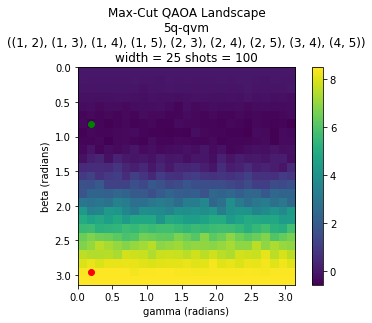

Calculated Cost: -0.465


In [17]:
width = 25

costs, betas, gammas, plot = run_mis_qaoa_landscape(qvm, num_nodes, elist, delta, U, omega, width, shots)
beta, gamma = optimal_params(costs, betas, gammas)
plot_landscape(plot, device=qvm.name, edges=elist, width=width, shots=shots)

calc_energy(beta, gamma)



  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 1/900 [00:00<09:06,  1.64it/s]

  0%|          | 2/900 [00:01<09:25,  1.59it/s]

  0%|          | 3/900 [00:02<09:47,  1.53it/s]

  0%|          | 4/900 [00:02<09:46,  1.53it/s]

  1%|          | 5/900 [00:03<09:39,  1.54it/s]

  1%|          | 6/900 [00:03<09:33,  1.56it/s]

  1%|          | 7/900 [00:04<09:30,  1.56it/s]

  1%|          | 8/900 [00:05<09:23,  1.58it/s]

  1%|          | 9/900 [00:05<09:22,  1.58it/s]

  1%|          | 10/900 [00:06<09:18,  1.59it/s]

  1%|          | 11/900 [00:07<09:14,  1.60it/s]

  1%|▏         | 12/900 [00:07<09:17,  1.59it/s]

  1%|▏         | 13/900 [00:08<09:17,  1.59it/s]

  2%|▏         | 14/900 [00:08<09:15,  1.60it/s]

  2%|▏         | 15/900 [00:09<09:11,  1.60it/s]

  2%|▏         | 16/900 [00:10<09:11,  1.60it/s]

  2%|▏         | 17/900 [00:10<09:07,  1.61it/s]

  2%|▏         | 18/900 [00:11<09:06,  1.61it/s]

  2%|▏         | 19/900 [00:11<09:02,  1.62it/s]

  2%|▏         |

 32%|███▏      | 288/900 [03:03<06:16,  1.63it/s]

 32%|███▏      | 289/900 [03:03<06:14,  1.63it/s]

 32%|███▏      | 290/900 [03:04<06:14,  1.63it/s]

 32%|███▏      | 291/900 [03:04<06:12,  1.64it/s]

 32%|███▏      | 292/900 [03:05<06:21,  1.59it/s]

 33%|███▎      | 293/900 [03:06<06:38,  1.52it/s]

 33%|███▎      | 294/900 [03:07<06:57,  1.45it/s]

 33%|███▎      | 295/900 [03:07<06:59,  1.44it/s]

 33%|███▎      | 296/900 [03:08<06:56,  1.45it/s]

 33%|███▎      | 297/900 [03:09<06:55,  1.45it/s]

 33%|███▎      | 298/900 [03:09<07:01,  1.43it/s]

 33%|███▎      | 299/900 [03:10<06:57,  1.44it/s]

 33%|███▎      | 300/900 [03:11<06:55,  1.44it/s]

 33%|███▎      | 301/900 [03:11<06:53,  1.45it/s]

 34%|███▎      | 302/900 [03:12<06:48,  1.46it/s]

 34%|███▎      | 303/900 [03:13<06:48,  1.46it/s]

 34%|███▍      | 304/900 [03:13<06:44,  1.47it/s]

 34%|███▍      | 305/900 [03:14<06:43,  1.48it/s]

 34%|███▍      | 306/900 [03:15<06:41,  1.48it/s]

 34%|███▍      | 307/900 [03:15

 64%|██████▍   | 574/900 [06:10<03:31,  1.54it/s]

 64%|██████▍   | 575/900 [06:11<03:30,  1.55it/s]

 64%|██████▍   | 576/900 [06:11<03:27,  1.56it/s]

 64%|██████▍   | 577/900 [06:12<03:25,  1.57it/s]

 64%|██████▍   | 578/900 [06:13<03:23,  1.59it/s]

 64%|██████▍   | 579/900 [06:13<03:23,  1.58it/s]

 64%|██████▍   | 580/900 [06:14<03:21,  1.58it/s]

 65%|██████▍   | 581/900 [06:14<03:21,  1.58it/s]

 65%|██████▍   | 582/900 [06:15<03:19,  1.59it/s]

 65%|██████▍   | 583/900 [06:16<03:19,  1.59it/s]

 65%|██████▍   | 584/900 [06:16<03:19,  1.58it/s]

 65%|██████▌   | 585/900 [06:17<03:17,  1.60it/s]

 65%|██████▌   | 586/900 [06:18<03:16,  1.60it/s]

 65%|██████▌   | 587/900 [06:18<03:14,  1.61it/s]

 65%|██████▌   | 588/900 [06:19<03:24,  1.53it/s]

 65%|██████▌   | 589/900 [06:20<03:22,  1.53it/s]

 66%|██████▌   | 590/900 [06:20<03:19,  1.55it/s]

 66%|██████▌   | 591/900 [06:21<03:17,  1.56it/s]

 66%|██████▌   | 592/900 [06:22<03:21,  1.53it/s]

 66%|██████▌   | 593/900 [06:22

 96%|█████████▌| 860/900 [09:14<00:24,  1.60it/s]

 96%|█████████▌| 861/900 [09:15<00:24,  1.62it/s]

 96%|█████████▌| 862/900 [09:15<00:23,  1.62it/s]

 96%|█████████▌| 863/900 [09:16<00:23,  1.58it/s]

 96%|█████████▌| 864/900 [09:17<00:22,  1.57it/s]

 96%|█████████▌| 865/900 [09:17<00:22,  1.57it/s]

 96%|█████████▌| 866/900 [09:18<00:21,  1.58it/s]

 96%|█████████▋| 867/900 [09:19<00:20,  1.60it/s]

 96%|█████████▋| 868/900 [09:19<00:20,  1.60it/s]

 97%|█████████▋| 869/900 [09:20<00:19,  1.60it/s]

 97%|█████████▋| 870/900 [09:20<00:18,  1.61it/s]

 97%|█████████▋| 871/900 [09:21<00:18,  1.59it/s]

 97%|█████████▋| 872/900 [09:22<00:17,  1.60it/s]

 97%|█████████▋| 873/900 [09:22<00:18,  1.48it/s]

 97%|█████████▋| 874/900 [09:23<00:17,  1.50it/s]

 97%|█████████▋| 875/900 [09:24<00:16,  1.53it/s]

 97%|█████████▋| 876/900 [09:24<00:15,  1.55it/s]

 97%|█████████▋| 877/900 [09:25<00:14,  1.57it/s]

 98%|█████████▊| 878/900 [09:26<00:13,  1.59it/s]

 98%|█████████▊| 879/900 [09:26

The minimum cost is: -0.625
The optimal beta value(s): (0.9749770304244186,)
The optimal gamma value(s): (1.8416232796905685,)


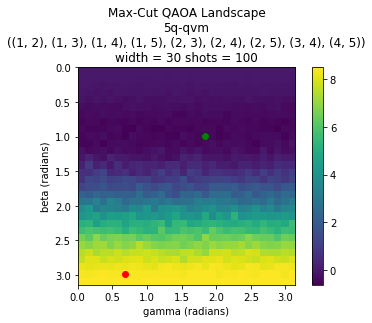

Calculated Cost: -0.435


In [15]:
width = 30

costs, betas, gammas, plot = run_mis_qaoa_landscape(qvm, num_nodes, elist, delta, U, omega, width, shots)
beta, gamma = optimal_params(costs, betas, gammas)
plot_landscape(plot, device=qvm.name, edges=elist, width=width, shots=shots)

calc_energy(beta, gamma)

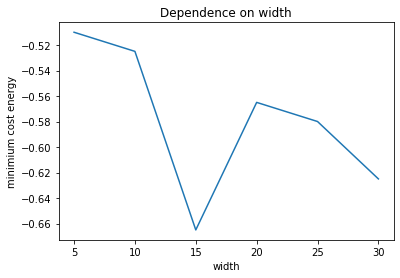

In [24]:
plt.plot([5, 10, 15, 20, 25, 30], [-0.51, -0.525, -0.665, -0.565, -0.58, -0.625]) 
plt.title("Dependence on width")
plt.xlabel("width")
plt.ylabel("minimium cost energy")
# plt.savefig("width.png")
plt.show()


  6%|▌         | 594/10000 [00:47<12:26, 12.59it/s]


 12%|█▏        | 1184/10000 [01:35<11:38, 12.62it/s]


 18%|█▊        | 1768/10000 [02:22<10:59, 12.48it/s]


 24%|██▎       | 2352/10000 [03:10<11:07, 11.46it/s]


 29%|██▉       | 2936/10000 [03:59<10:11, 11.56it/s]


 35%|███▌      | 3520/10000 [04:46<09:01, 11.97it/s]


 41%|████      | 4104/10000 [05:33<08:27, 11.62it/s]


 47%|████▋     | 4688/10000 [06:21<07:15, 12.19it/s]


 53%|█████▎    | 5272/10000 [07:09<06:39, 11.83it/s]


 59%|█████▊    | 5856/10000 [07:57<05:40, 12.15it/s]


 64%|██████▍   | 6435/10000 [08:46<04:55, 12.08it/s]


 70%|███████   | 7019/10000 [09:34<04:00, 12.40it/s]


 76%|███████▌  | 7603/10000 [10:22<03:14, 12.32it/s]


 82%|████████▏ | 8187/10000 [11:10<02:39, 11.35it/s]


 88%|████████▊ | 8771/10000 [12:01<01:45, 11.60it/s]


 94%|█████████▎| 9355/10000 [12:53<01:01, 10.57it/s]


 99%|█████████▉| 9921/10000 [13:45<00:06, 12.00it/s]


100%|██████████| 10000/10000 [13:52<00:00, 12.02it/s]

The minimum cost is: -1.2
The optimal beta value(s): (2.0943951023931953, 2.443460952792061)
The optimal gamma value(s): (2.443460952792061, 1.0471975511965976)


TypeError: Invalid shape (10, 10, 10, 10) for image data

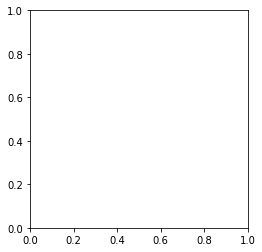

In [12]:
# For p = 2, width = 10, shots = 10
costs, beta, gamma, plot = run_mis_qaoa_landscape(qvm, num_nodes, elist, delta, U, omega, width, shots)
optimal_params(costs, beta, gamma)
plot_landscape(plot, device=qvm.name, edges=elist, width=width, shots=shots)

In [14]:
calc_energy([2.0943951023931953, 2.443460952792061], [2.443460952792061, 1.0471975511965976])

Calculated Cost: -0.45
